In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from fancyimpute import KNN
from ggplot import *
import warnings


Using TensorFlow backend.


In [2]:
# To remove warnings
warnings.simplefilter('ignore')

In [3]:
os.chdir ("D:/edwisor/CabFarePrediction_Python")

In [4]:
#read  csv data and save in a variable
train = pd.read_csv("train_cab.csv")
test = pd.read_csv("test.csv")

In [5]:
train.shape

(16067, 7)

In [6]:
test.shape

(9914, 6)

# Data Cleanup Process

In [7]:
train["fare_amount"] = pd.to_numeric(train["fare_amount"], errors = "coerce")
for i in [train,test]:
    i["pickup_datetime"] = pd.to_datetime(i["pickup_datetime"], errors ="coerce")
    
    i["year"] = i["pickup_datetime"].dt.year
    i["year"] = (i["year"]).astype("object")
    i["month"] = i["pickup_datetime"].dt.month
    i["month"] = (i["month"]).astype("object")
    i["day"] = i["pickup_datetime"].dt.day
    i["day"] = (i["day"]).astype("object")
    i["hour"] = i["pickup_datetime"].dt.hour
    i["hour"] = (i["hour"]).astype("object")
    i["weekday"] = i["pickup_datetime"].dt.dayofweek
    i["weekday"] = (i["weekday"]).astype("object")
    i["pickup_datetime"] = i["pickup_datetime"].astype('str')

In [8]:
# calculate distance between pickup and dropoff
def havrsine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        d = (R * c) #in kilometers
        i['distance'] = d


In [9]:
havrsine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [10]:
# re order columns, and put fare_amount in last column as this is the target variable 
train = train.reindex(list(train.columns[1:])+["fare_amount"],axis = 1)


In [11]:
train.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
year                  object
month                 object
day                   object
hour                  object
weekday               object
distance             float64
fare_amount          float64
dtype: object

In [12]:
test.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
year                  object
month                 object
day                   object
hour                  object
weekday               object
distance             float64
dtype: object

In [13]:
train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,fare_amount
count,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000,16067.000000,16042.000000
mean,-72.462787,39.914725,-72.462328,39.897906,2.625070,16.025699,15.015004
std,10.578384,6.826587,10.575062,6.187087,60.844122,324.804396,430.460945
min,-74.438233,-74.006893,-74.429332,-74.006377,0.000000,0.000000,-3.000000
25%,-73.992156,40.734927,-73.991182,40.734651,1.000000,1.214647,6.000000
50%,-73.981698,40.752603,-73.980172,40.753567,1.000000,2.125326,8.500000
75%,-73.966838,40.767381,-73.963643,40.768013,2.000000,3.847232,12.500000
max,40.766125,401.083332,40.802437,41.366138,5345.000000,8667.542104,54343.000000


In [14]:
#There are some anamolies we need to remove
#Longitude valid range  be +/-180 degree
#Latitude range is  +/- 90, but in pickup latitude max is 401.08 which is invalid
#Passenger count minimum is 0 which is not possible and maximum is 5345 which is also unreal
#so lets assume maximum passenger count be 20 ( lets assume cab can be  is a mini bus too)
#fare amount cannot be negative
#So we need to remove these anomalies


train =  train[((train['pickup_longitude'] > -180) & (train['pickup_longitude'] < 180)) & 
               ((train['dropoff_longitude'] > -180) & (train['dropoff_longitude'] < 180)) & 
               ((train['pickup_latitude'] > -90) & (train['pickup_latitude'] < 90)) & 
               ((train['dropoff_latitude'] > -90) & (train['dropoff_latitude'] < 90)) & 
               (train['passenger_count'] > 0) & (train['passenger_count'] <=20) & (train['fare_amount']>0)]

In [15]:
train.shape

(15906, 13)

In [16]:
train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,fare_amount
count,15906.000000,15906.000000,15906.000000,15906.000000,15906.000000,15906.000000,15906.000000
mean,-72.475365,39.898995,-72.465627,39.899527,1.649467,15.068223,15.064285
std,10.537154,6.185843,10.565076,6.185468,1.265771,311.693241,432.296590
min,-74.438233,-74.006893,-74.429332,-74.006377,0.120000,0.000000,0.010000
25%,-73.992144,40.734943,-73.991182,40.734705,1.000000,1.215848,6.000000
50%,-73.981691,40.752633,-73.980161,40.753565,1.000000,2.126809,8.500000
75%,-73.966817,40.767377,-73.963644,40.768015,2.000000,3.855717,12.500000
max,40.766125,41.366138,40.802437,41.366138,6.000000,8667.542104,54343.000000


In [17]:
numerical = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance','fare_amount']

In [18]:
categorical = ['pickup_datetime', 'year',
       'month', 'day', 'hour', 'weekday']

{'whiskers': [<matplotlib.lines.Line2D at 0x22265b5b780>,
 'caps': [<matplotlib.lines.Line2D at 0x22265b5be10>,
 'boxes': [<matplotlib.lines.Line2D at 0x22265b5b320>],
 'medians': [<matplotlib.lines.Line2D at 0x22265b724e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22265b72828>],
 'means': []}

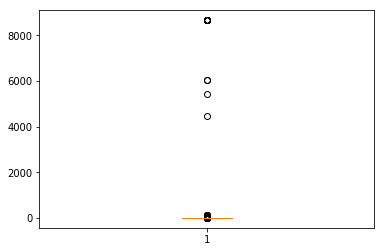

In [19]:
# Outliers in Numerical Variables
#boxplot to visualise outlier
%matplotlib inline
plt.boxplot(train["distance"])

In [20]:
# we can see there are some outliers in distance
# lets count outliers if they are less then remove them
train.loc[(train["distance"]>200),"distance"].count()
# the outliers are only 23 out of 15906 so we can remove it

23

In [21]:
#Remove distance outliers
train = train.drop(train.loc[(train["distance"]>200),:].index, axis=0)

In [22]:
train.shape

(15883, 13)

{'whiskers': [<matplotlib.lines.Line2D at 0x22265be0e80>,
 'caps': [<matplotlib.lines.Line2D at 0x22265beb550>,
 'boxes': [<matplotlib.lines.Line2D at 0x22265be0a58>],
 'medians': [<matplotlib.lines.Line2D at 0x22265bebbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22265bebf28>],
 'means': []}

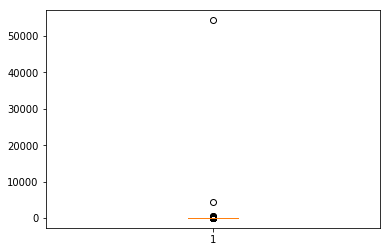

In [23]:
plt.boxplot(train["fare_amount"])

In [24]:
# we can see there are some outliers in farre_amount
# lets count outliers if they are less then remove them
train.loc[(train["fare_amount"]>200),"fare_amount"].count()
# the outliers are only 4 out of 15883 so we can remove it

4

In [25]:
#Remove outliers in fare_amount
train = train.drop(train.loc[(train["fare_amount"]>200),:].index, axis=0)

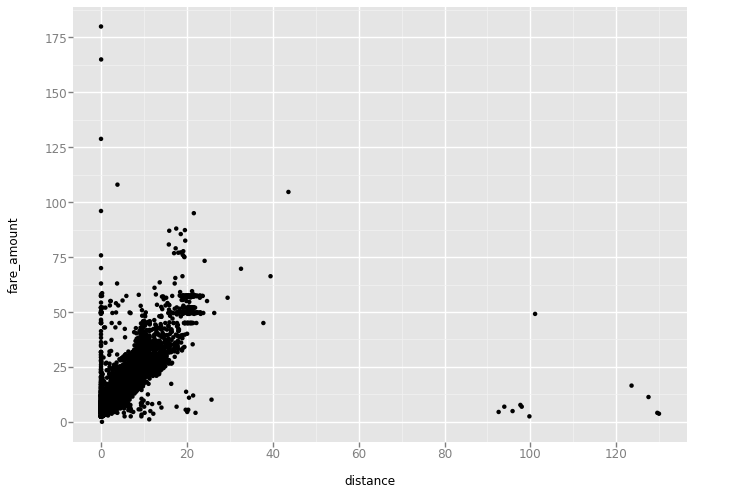

<ggplot: (146672455737)>

In [26]:
#scatter plot between distance and fare amount 
from ggplot import *

ggplot( aes(x = 'distance', y = "fare_amount"),data = train) + geom_point()

In [27]:
# In scatter plot we can see that at some points where distance is 0, fare is not 0 so we need  count these anamolies
train.loc[(train["distance"]==0)&train["fare_amount"]>0,"distance"].count()
#this is 454 and a 2% of total data so we can remove them as well


454

In [28]:
train = train.drop(train.loc[((train["distance"]==0)&train["fare_amount"]>0),:].index, axis=0)

In [29]:
train.shape

(15425, 13)

In [30]:
# similarly if fare is 0 then distance cannot be >0
train.loc[(train["fare_amount"]==0)&train["distance"]>0,"fare_amount"].count()

0

In [31]:
#check observations when fare and distance both 0,
train.loc[(train["fare_amount"]==0)&(train["distance"]==0),"fare_amount"].count()

0

In [32]:
#Remove rows where passenger count is 0
train = train.drop(train.loc[(train["passenger_count"]==0),:].index, axis=0)

In [33]:
train.shape

(15425, 13)

In [34]:
missing_val = pd.DataFrame(train.isnull().sum())

In [35]:
missing_val

,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
year,1
month,1
day,1
hour,1


In [36]:
# there is only one row which has null value So we can remove it
train  = train.drop(train.loc[(train["year"].isnull()),:].index, axis=0)

In [37]:
#We can remove pickup_datetime as it doesnt have much information in general
train = train.drop(['pickup_datetime'], axis = 1)
test = test.drop(['pickup_datetime'], axis = 1)

In [38]:
train.shape

(15424, 12)

# Work on given test data variables

In [39]:
test.dtypes

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
year                  object
month                 object
day                   object
hour                  object
weekday               object
distance             float64
dtype: object

In [40]:
train.dtypes

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
year                  object
month                 object
day                   object
hour                  object
weekday               object
distance             float64
fare_amount          float64
dtype: object

In [41]:
train.loc[:,"passenger_count"] = train.loc[:,"passenger_count"].astype('int64')

In [42]:
train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,fare_amount
count,15424.000000,15424.000000,15424.000000,15424.000000,15424.000000,15424.000000,15424.000000
mean,-73.910872,40.688601,-73.909897,40.689101,1.651776,3.442776,11.314442
std,2.679344,2.633265,2.679454,2.632917,1.267724,4.597316,9.472102
min,-74.438233,-74.006893,-74.227047,-74.006377,0.000000,0.000111,0.010000
25%,-73.992375,40.736565,-73.991368,40.736296,1.000000,1.277861,6.000000
50%,-73.982075,40.753345,-73.980567,40.754242,1.000000,2.191322,8.500000
75%,-73.968152,40.767802,-73.965512,40.768310,2.000000,3.937860,12.500000
max,40.766125,41.366138,40.802437,41.366138,6.000000,129.950482,165.000000


In [43]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,3.435371
std,0.042774,0.033541,0.039072,0.035435,1.278747,3.972374
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,1.298277
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,2.217412
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,4.045302
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,99.996040


# Visualaization and  Feature Selection

In [44]:
##Correlation analysis As all data is Numerical
#Assume that there should be no dependency between independent variables 
#Assume that there should be high dependency between independent variables and independent variable
#Correlation plot
train_corr = train.loc[:,numerical]

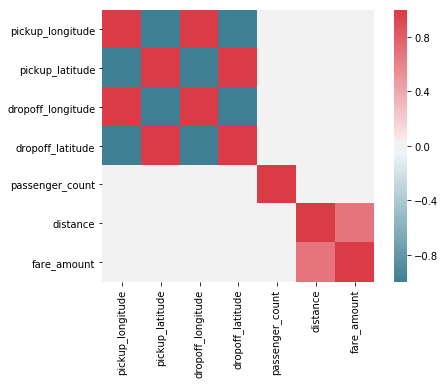

In [45]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = train_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [46]:
train.shape

(15424, 12)

In [47]:
#we can remove all the geolocation points as they are highly corelated and distance is actually derived from these variables
# Also we can see that fare amount depends on week, day and date as desplayed in following scatter graphs

train = train.drop(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'], axis = 1)
test = test.drop(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'], axis = 1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

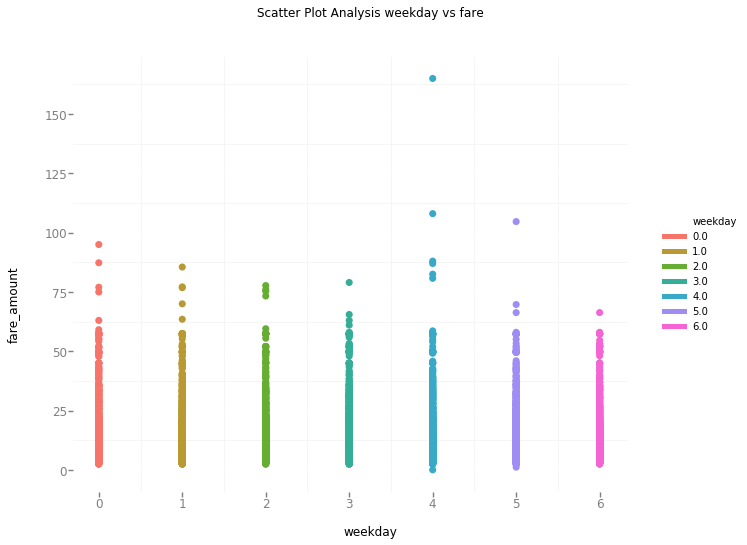

<ggplot: (146672503030)>

In [48]:

# How week days affect fare_amount
ggplot(train, aes(x = 'weekday', y = 'fare_amount', color='weekday')) + \
    geom_point(alpha = 1, size = 50) + theme_bw()+ ylab("fare_amount") + xlab("weekday") + ggtitle("Scatter Plot Analysis weekday vs fare")
# maximum fare is on friday, Monday, Tuesday, wednesday and low fares on Sunday 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

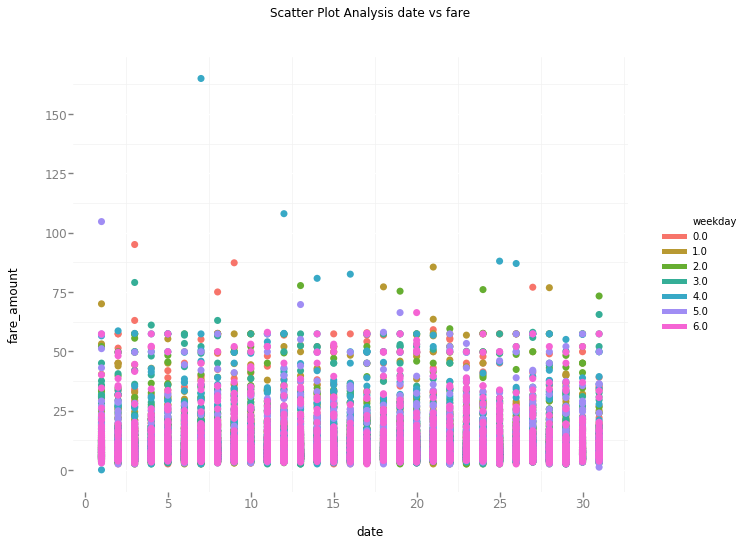

<ggplot: (-9223371890182214589)>

In [49]:
#Impact of date on fare_amount
ggplot(train, aes(x = 'day', y = 'fare_amount', color='weekday')) + \
    geom_point(alpha = 1, size = 50) + theme_bw()+ ylab("fare_amount") + xlab("date") + ggtitle("Scatter Plot Analysis date vs fare")
# If fare is affected by date Maximum is around 7th but fare is almost same on all days so date doesnt affect fare amount

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

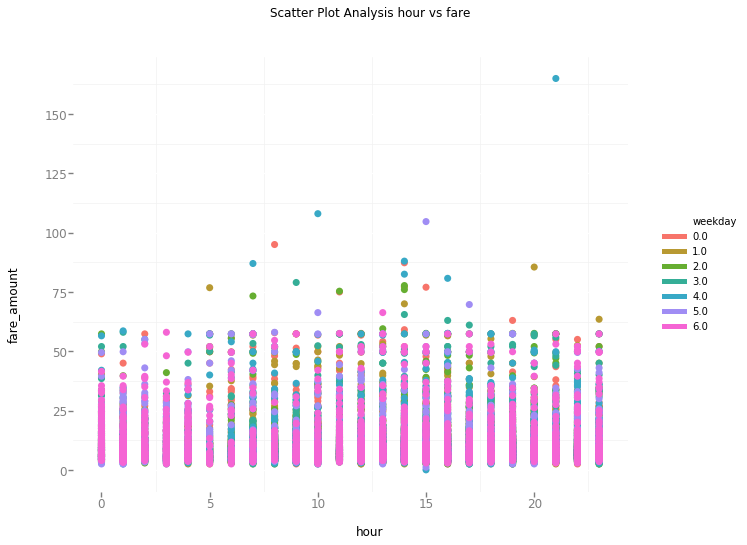

<ggplot: (-9223371890182218117)>

In [50]:
#Impact of hour on fare_amount
ggplot(train, aes(x = 'hour', y = 'fare_amount', color='weekday')) + \
    geom_point(alpha = 1, size = 50) + theme_bw()+ ylab("fare_amount") + xlab("hour") + ggtitle("Scatter Plot Analysis hour vs fare")
# we can see that fare amount is less in the nights sometimes but mostly alomost same

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

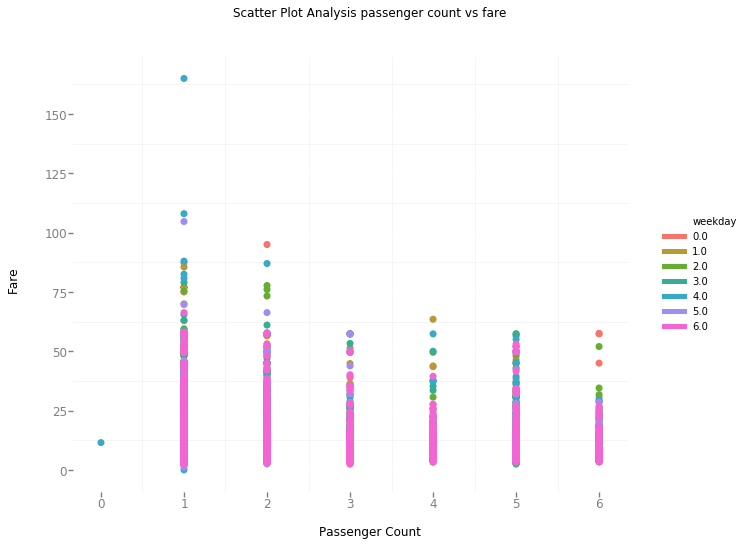

<ggplot: (-9223371890182214631)>

In [51]:
# impact of passenger count on fare
ggplot(train, aes(x = 'passenger_count', y = 'fare_amount', color='weekday')) + \
    geom_point(alpha = 1, size = 50) + theme_bw()+ ylab("Fare") + xlab("Passenger Count") + ggtitle("Scatter Plot Analysis passenger count vs fare")

# If fare is affected by passenger count, highest when passenger count is 1-2

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

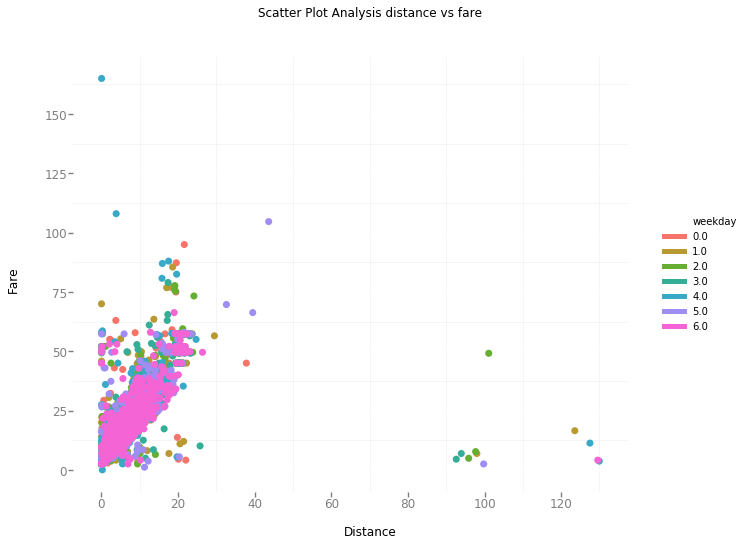

<ggplot: (146673482381)>

In [52]:
# distance impact on fare amount 
ggplot(train, aes(x = 'distance', y = 'fare_amount',color = 'weekday')) + \
    geom_point(alpha = 1, size = 50) + theme_bw()+ ylab("Fare") + xlab("Distance") + ggtitle("Scatter Plot Analysis distance vs fare")
#We can see thta more the distane more the fare, so clearly fare amount is highly positively corelated with distance

In [53]:
train.dtypes

passenger_count      int64
year                object
month               object
day                 object
hour                object
weekday             object
distance           float64
fare_amount        float64
dtype: object

In [54]:
test.dtypes

passenger_count      int64
year                object
month               object
day                 object
hour                object
weekday             object
distance           float64
dtype: object

In [55]:
#train = df.copy()

In [56]:
train.columns

Index(['passenger_count', 'year', 'month', 'day', 'hour', 'weekday',
       'distance', 'fare_amount'],
      dtype='object')

In [57]:
test.columns

Index(['passenger_count', 'year', 'month', 'day', 'hour', 'weekday',
       'distance'],
      dtype='object')

# Feature Scaling

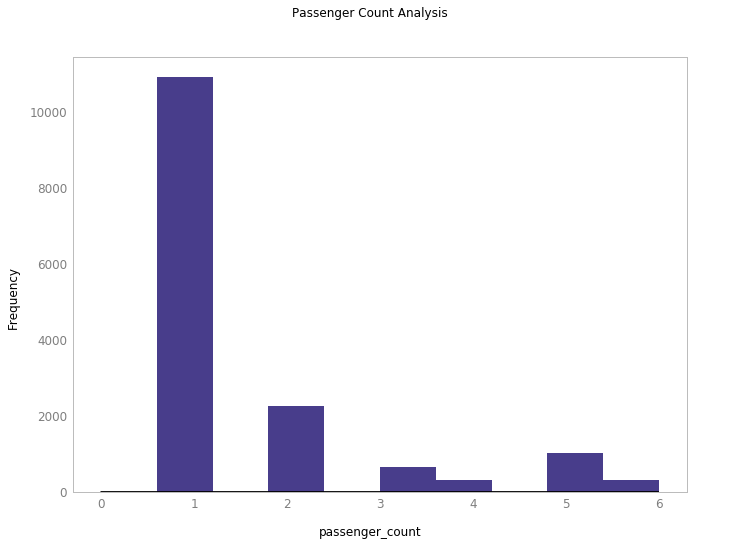

<ggplot: (146673559346)>

In [58]:
#feature scaling is always for continuous variables
#Normality check
ggplot(train, aes(x = 'passenger_count')) + geom_histogram(fill="DarkSlateBlue", colour = "black") +\
    geom_density() +\
    theme_bw() + xlab("passenger_count") + ylab("Frequency") + ggtitle("Passenger Count Analysis") +\
    theme(text=element_text(size=20))

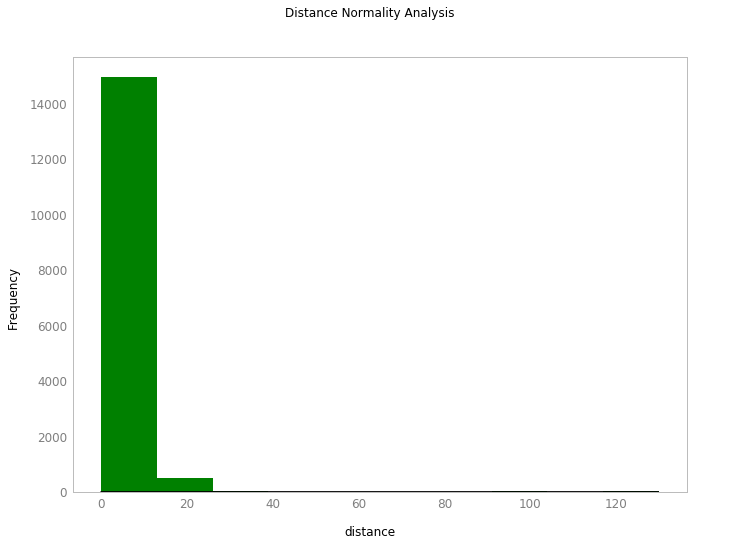

<ggplot: (146673795055)>

In [59]:

ggplot(train, aes(x = 'distance')) + geom_histogram(fill="Green", colour = "black") +\
    geom_density() +\
    theme_bw() + xlab("distance") + ylab("Frequency") + ggtitle("Distance Normality Analysis") +\
    theme(text=element_text(size=20))

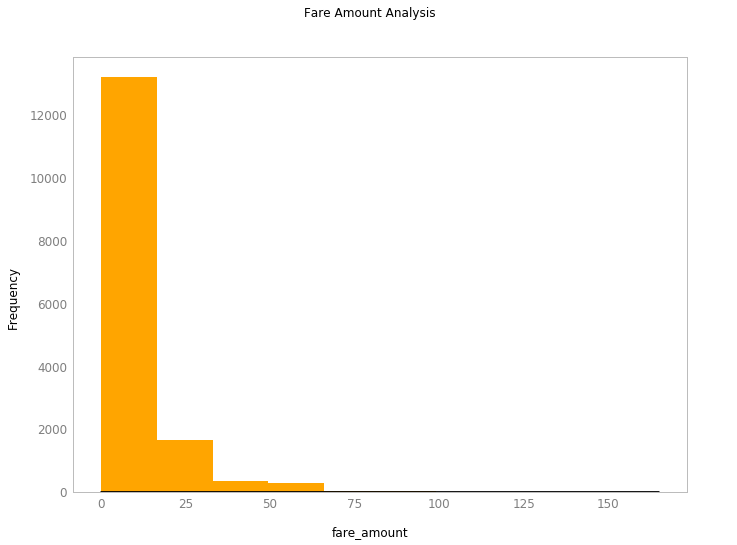

<ggplot: (-9223371890180956942)>

In [60]:

ggplot(train, aes(x = 'fare_amount')) + geom_histogram(fill="Orange", colour = "black") +\
    geom_density() +\
    theme_bw() + xlab("fare_amount") + ylab("Frequency") + ggtitle("Fare Amount Analysis") +\
    theme(text=element_text(size=20))

In [61]:
train.columns

Index(['passenger_count', 'year', 'month', 'day', 'hour', 'weekday',
       'distance', 'fare_amount'],
      dtype='object')

In [62]:
#As the data is not equally distributed so we will go with Nomalisation
for i in ['passenger_count', 'distance']:
    print(i)
    train[i] = (train[i] - min(train[i]))/(max(train[i]) - min(train[i]))
    test[i] = (test[i] - min(test[i]))/(max(test[i]) - min(test[i]))

passenger_count
distance


In [63]:
train.head()

,passenger_count,year,month,day,hour,weekday,distance,fare_amount
0,0.166667,2009,6,15,17,0,0.007931,4.5
1,0.166667,2010,1,5,16,1,0.065025,16.9
2,0.333333,2011,8,18,0,3,0.010692,5.7
3,0.166667,2012,4,21,4,5,0.021540,7.7
4,0.166667,2010,3,9,7,1,0.015383,5.3


# Model development

# Linear Regression

In [64]:
x = train.copy()
#train = x.copy()
# we need to sample train data again in test and train so that we can apply model on sample 
from sklearn.model_selection import train_test_split
train,sample = train_test_split(train,test_size=0.25)

In [65]:
train.shape

(11568, 8)

In [66]:
# for linear regression we need continuous variables so convert  all the data in numeric
train_linear = train.copy()
sample_linear = sample.copy()
for j in [train_linear,sample_linear]:
    for i in range(0, j.shape[1]):
        if(j.iloc[:,i].dtypes == "object"):
            j.iloc[:,i] = pd.to_numeric(j.iloc[:,i])


In [67]:
#First start with Linear Regression
#Import Libraries for LR
#import models for libear regression
# As  the target v
import statsmodels.api as sm

In [68]:
sample.shape

(3856, 8)

In [69]:
#train models using the training sets (optimum least swuare method to calculate coefficient)
#parameters dependent variable , independent variables
lmodel = sm.OLS(train_linear.iloc[:,7], train_linear.iloc[:,0:7]).fit()

In [70]:
lmodel.summary()
#rSquared 78.3%  dependent variable can be is explained by independent variables

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     5724.
Date:                Sat, 13 Jul 2019   Prob (F-statistic):               0.00
Time:                        00:16:53   Log-Likelihood:                -38929.
No. Observations:               11568   AIC:                         7.787e+04
Df Residuals:                   11561   BIC:                         7.792e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
passenger_count     0.5442      0.306      1.778      0.075      -0.056       1.144
year                0.0031      0.000     23.567      0.000       0.003       0.003
month               0.0906      0.019      4.804      0.000       0.054       0.128
day                -0.0086      0.007     -1.145      0.252      -0.023       0.006
hour               -0.0191      0.010     -1.907      0.057      -0.039       0.001
weekday            -0.0578      0.033     -1.745      0.081      -0.123       0.007
distance          183.5021      1.857     98.804      0.000     179.862     187.143
==============================================================================
Omnibus:                    12496.811   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20125205.813
Skew:                          -4.417   Prob(JB):                         0.00
Kurtosis:                     207.146   Cond. No.                     5.74e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
lr_prediction = lmodel.predict(sample_linear.iloc[:,0:7])

In [72]:
#Calculate MAPE
def mape(y_true,y_pred):
    #print(np.mean(abs((y_true-y_pred)/y_true)))*100
    return 'Test MAPE : %.3f' % (np.mean(abs((y_true-y_pred)/y_true))*100)

In [73]:
#Caclulate RMSE
from sklearn.metrics import mean_squared_error
def RMSE (y_true,y_pred):
    return("Test RMSE: %.3f" % mean_squared_error(y_true, y_pred) ** 0.5)

In [74]:
mape(sample_linear.iloc[:,7],lr_prediction)

'Test MAPE : 34.422'

In [75]:
RMSE(sample_linear.iloc[:,7],lr_prediction)

'Test RMSE: 6.441'

In [76]:
#train = x.copy()

# Decision Regression Tree

In [77]:
#decision Tree for regression (max_depth = 2 means max branch for any node should be 2)
from sklearn.tree import DecisionTreeRegressor
DT_regression = DecisionTreeRegressor(max_depth = 7).fit(train.iloc[:,0:7],train.iloc[:,7])

In [78]:
#apply Data model on Test
DT_prediction = DT_regression.predict(sample.iloc[:,0:7])

In [79]:
mape(sample.iloc[:,7],DT_prediction)

'Test MAPE : 20.562'

In [80]:
RMSE(sample.iloc[:,7],DT_prediction)

'Test RMSE: 3.999'

# Random forest

In [81]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

In [82]:
RF_Model = RandomForestRegressor(n_estimators=150).fit(train.iloc[:,0:7],train.iloc[:,7])

In [83]:
RF_prediction = RF_Model.predict(sample.iloc[:,0:7])

In [84]:
mape(sample.iloc[:,7],RF_prediction)

'Test MAPE : 21.368'

In [85]:
RMSE(sample.iloc[:,7],RF_prediction)

'Test RMSE: 3.783'

# KNN ML Algo


In [86]:
from sklearn.neighbors import KNeighborsRegressor
KN_Model = KNeighborsRegressor(n_neighbors=60).fit(train.iloc[:,0:7],train.iloc[:,7])

In [87]:
KN_prediction = KN_Model.predict(sample.iloc[:,0:7])

In [88]:
mape(sample.iloc[:,7],KN_prediction)

'Test MAPE : 60.693'

In [89]:
RMSE(sample.iloc[:,7],KN_prediction)

'Test RMSE: 9.211'

# Best Predictor is Random Decision Tree so predict actual test data using DT and save it in CSV

In [90]:
test["fare_amount"]=0

In [91]:
test.shape

(9914, 8)

In [92]:
final_test =pd.DataFrame(RF_Model.predict(test.iloc[:,0:7]))

In [93]:
final_test.head()

,0
0,11.776000
1,13.192667
2,5.346667
3,10.844000
4,20.218733


In [94]:
test_submission = pd.read_csv("test.csv")

In [95]:
test_submission["fare_amount"] = final_test

In [96]:
test_submission.to_csv("test_submission.csv")